In [28]:
import numpy as np

from engine import RMG, AdvRw
from agent import RandomAgent, IndQLearningAgent, FPLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed

In [ ]:
A = np.array([[[1,2],[3,4]]])

# print(np.argmax(A,axis=1))
# print(A[:,:])
# print(A.shape)
# print(np.dot(A[0,:,:], np.array([0.3,0.7])))

# print(np.tensordot(A, np.array([0.3,0.7]), axes=([2],[0])))

A = np.array([[1,2],[3,4]])
B = np.array([[0.6,0.4],[0.2,0.8]])

print(np.argmax(B,axis=1))
print(B[:,:])
print(B.shape)
print(np.dot(B[:,:], np.array([1,2])))

print(np.tensordot(B, np.array([1,2]), axes=([1],[0])))

print(np.tensordot(B, A, axes=([1],[1])))

result = np.sum(A * B, axis=1)
print(A*B)
print(result)


[0 1]
[[0.6 0.4]
 [0.2 0.8]]
(2, 2)
[1.4 1.8]
[1.4 1.8]
[[1.4 3.4]
 [1.8 3.8]]
[1.4 3.8]


In [39]:
possible_actions = [0, 1]  # Target A or B
gamma = 0.8

rw_agents = []
agents = [IndQLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed]


for agent in agents:
    
    print('Beginning experiments with agent ', agent.__name__)

    N_EXP = 20

    r0ss = []

    smooth = 100

    for n in range(N_EXP):
        batch_size = 1
        max_steps = 1

        mode = 'adversary'
        env = AdvRw(mode, p=0.6)  # p is only used in neutral mode
        
        # Getting reward table for the current agent
        reward_table = env.get_reward_table()
        
        env.reset()

        p = agent(possible_actions, enemy_action_space=possible_actions, n_states=1, learning_rate=0.1, epsilon=0.1, gamma=gamma)

        # Stateless interactions (agents do not have memory)
        s = 0

        n_iter = 5000 + smooth # because of the smoothening in the graphics

        r0s = []
        r1s = []

        for i in range(n_iter):

            # A full episode:
            done = False

            while not done:

                # Agents decide
                a0 = p.act(obs=s)

                a1 = env.act()
                
                # World changes
                _, (r0, r1), done, _ = env.step(a0,a1)
    
                #r1 = -r0
                # !!! This sets the reward to the adversary to 0 or 1 respectively,
                # !!! if the following line was commented out, it would lead to correct zero sum-game as described in Stateless variant section of the experiemts.
                # !!! This line leads to graph reported in the paper. True zero-sum produces similar graph but without growing trend at the beggining.
                r1 = float(r0 < 0) 
                #r1 = float(r0 < 0) - 1
                #r1 = float(r0 < 0)*0.05
                #r1 = float(r0 < 0)*2 - 1
                p.update(s, (a0, a1), (r0, r1) , s )

                #s = new_s  #stateless!

                r0s.append(r0)

            env.reset()

        r0ss.append(r0s)
        
    rw_agents.append(r0ss)

Beginning experiments with agent  IndQLearningAgent
Beginning experiments with agent  FPQwForgetAgent
Beginning experiments with agent  Level2QAgent
Beginning experiments with agent  Level2QAgent_fixed


In [31]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

We report moving avearage of rewards, since it's common in RL taks

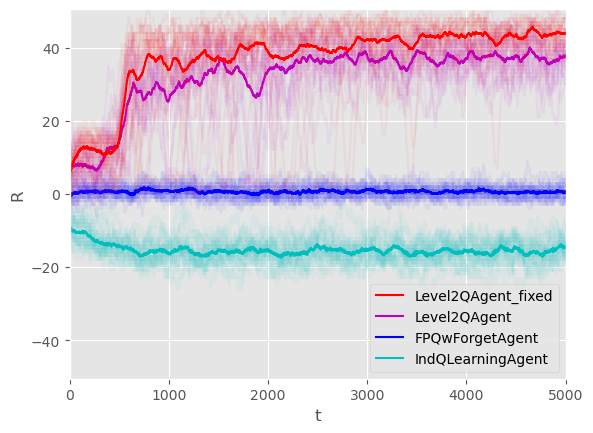

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

# We set a fancy theme
plt.style.use('ggplot')

colors = 'cbmr'
plt.axis([0, max_steps*n_iter - smooth, -50.5, 50.5])
for j,a in enumerate(agents):
    r0ss = rw_agents[j]
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), colors[j], alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), colors[j], alpha=1)

plt.xlabel('t')
plt.ylabel('R')

from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=colors[::-1][i]) for i,_ in enumerate(agents)]

plt.legend(custom_lines,[a.__name__ for a in reversed(agents)], loc=4)

plt.savefig('img/4C_08_binary' + mode + '.png')

For the adversary case (no forget):

In [33]:
def calculate_DM_statistics(rw_agents, agent_index):
    # Convert the selected agent's rewards to a NumPy array
    rewards = np.asarray(rw_agents[agent_index])
    
    # Calculate cumulative sum along axis 1
    cumulative_rewards = rewards.cumsum(axis=1)
    
    # Mean of cumulative rewards for all steps, across all experiments
    mean_cumulative_rewards_all_steps = cumulative_rewards.mean(axis=0).mean()
    formatted_mean_cumulative_rewards_all_steps = f"{mean_cumulative_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean of cumulative rewards for last step, across all experiments
    mean_cumulative_rewards_last_step = cumulative_rewards[:,-1].mean()
    formatted_mean_cumulative_rewards_last_step = f"{mean_cumulative_rewards_last_step:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards for all steps, across all experiments
    mean_variance_all_steps = cumulative_rewards.var(axis=0).mean()
    formatted_mean_variance_all_steps = f"{mean_variance_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards only last step, across all experiments
    mean_variance_last_step = cumulative_rewards[:, -1].var(axis=0)
    formatted_mean_variance_last_step = f"{mean_variance_last_step:,.2f}".replace(",", " ")
    
    # Cumulative rewards at the last step
    cumulative_rewards_last_step = cumulative_rewards[:, -1]
    
    # Mean of rewards for all steps, across all experiments
    mean_rewards_all_steps = rewards.mean(axis=0).mean()
    formatted_mean_rewards_all_steps = f"{mean_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of rewards for all steps, across all experiments
    mean_variance_rewards_all_steps = rewards.var(axis=0).mean()
    formatted_mean_variance_rewards_all_steps = f"{mean_variance_rewards_all_steps:,.2f}".replace(",", " ")
    
    return {
        "mean_cumulative_rewards_all_steps": formatted_mean_cumulative_rewards_all_steps,
        "mean_cumulative_rewards_last_step": formatted_mean_cumulative_rewards_last_step,
        "mean_variance_all_steps": formatted_mean_variance_all_steps,
        "mean_variance_last_step": formatted_mean_variance_last_step,
        "cumulative_rewards_last_step": cumulative_rewards_last_step,
        "mean_rewards_all_steps": formatted_mean_rewards_all_steps,
        "mean_variance_rewards_all_steps": formatted_mean_variance_rewards_all_steps
    }
    

In [34]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-1)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])


Mean cumulative reward for all steps: 82 925.21
Mean cumulative reward for last step: 187 730.00
Mean variance of cumulative rewards for all steps: 36 348 122.54
Mean variance of cumulative rewards only last step: 49 382 100.00
Cumulative rewards at the last step: [186100 179300 185700 183900 189400 189300 195300 190100 188500 186600
 189900 196300 189500 194800 177500 199200 181200 199100 180400 172500]
Mean rewards for all steps: 36.81
Mean variance of rewards for all steps: 982.76


In [35]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-2)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 70 875.17
Mean cumulative reward for last step: 161 735.00
Mean variance of cumulative rewards for all steps: 20 448 906.73
Mean variance of cumulative rewards only last step: 28 167 275.00
Cumulative rewards at the last step: [161800 162400 160800 165700 164000 165600 160500 169200 158600 174300
 160300 165200 155500 150700 161500 164800 162500 162900 153300 155100]
Mean rewards for all steps: 31.71
Mean variance of rewards for all steps: 1 334.95


In [36]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-3)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 1 599.67
Mean cumulative reward for last step: 3 095.00
Mean variance of cumulative rewards for all steps: 620 959.46
Mean variance of cumulative rewards only last step: 751 475.00
Cumulative rewards at the last step: [2400 3500 2800 4900 2700 3100 3400 2900 2800 1700 3000 2400 4400 4100
 3000 3000 3300 1800 4700 2000]
Mean rewards for all steps: 0.61
Mean variance of rewards for all steps: 2 379.84


In [37]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-4)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: -38 068.08
Mean cumulative reward for last step: -77 990.00
Mean variance of cumulative rewards for all steps: 8 023 647.88
Mean variance of cumulative rewards only last step: 19 115 900.00
Cumulative rewards at the last step: [-76900 -77300 -74900 -81300 -73400 -66700 -83200 -86000 -76100 -77500
 -76300 -76700 -73700 -79400 -82200 -78500 -83300 -84000 -75000 -77400]
Mean rewards for all steps: -15.29
Mean variance of rewards for all steps: 2 148.27
